In [16]:
import time
import math

import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch
from torch import nn
from torch.optim import SGD
import seaborn as sns
import pandas as pd

from mup import MuSGD, get_shapes, set_base_shapes, make_base_shapes, MuReadout


'''
    PyTorch MLP on CIFAR-10, with μP.

    This is minimal notebook that demonstrates the hyperparameter stability of muP.
'''

batch_size = 64
epochs = 20
log_interval = 300
nonlin = torch.relu
criterion = F.cross_entropy
data_dir = '/tmp'
base_shapes_path = './demo_width256.bsh'

In [17]:
torch.manual_seed(1)
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True}

### Data processing

In [18]:
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = datasets.CIFAR10(root=data_dir, train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testset = datasets.CIFAR10(root=data_dir, train=False,
                                    download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

### Training and validation loops

In [19]:
def train(model, device, train_loader, optimizer, epoch,
            scheduler=None, criterion=F.cross_entropy):
    model.train()
    train_loss = 0
    correct = 0
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data.view(data.size(0), -1))
        
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item() * data.shape[0]  # sum up batch loss
        optimizer.step()
        if batch_idx % log_interval == 0:
            elapsed = time.time() - start_time
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} | ms/batch {:5.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                elapsed * 1000 / log_interval))
            start_time = time.time()
        if scheduler is not None:
            scheduler.step()
    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}\n'.format(
        train_loss, correct, len(train_loader.dataset)))
    return train_loss

### Model definitions

A simple MLP without biases.
We expose a few hyperparameters for further tuning: input/output multiplier and initialization standard deviation.

In [20]:
class MLP(nn.Module):
    def __init__(self, width=128, num_classes=10, nonlin=F.relu, output_mult=1.0, input_mult=1.0):
        super(MLP, self).__init__()
        self.nonlin = nonlin
        self.input_mult = input_mult
        self.output_mult = output_mult
        self.fc_1 = nn.Linear(3072, width, bias=False)
        self.fc_2 = nn.Linear(width, width, bias=False)
        self.fc_3 = nn.Linear(width, num_classes, bias=False)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        self.fc_1.weight.data /= self.input_mult**0.5
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')
        nn.init.zeros_(self.fc_3.weight)

    def forward(self, x):
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        out = self.nonlin(self.fc_2(out))
        return self.fc_3(out) * self.output_mult

class muMLP(nn.Module):
    def __init__(self, width=128, num_classes=10, nonlin=F.relu, output_mult=1.0, input_mult=1.0):
        super(muMLP, self).__init__()
        self.nonlin = nonlin
        self.input_mult = input_mult
        self.output_mult = output_mult
        self.fc_1 = nn.Linear(3072, width, bias=False)
        self.fc_2 = nn.Linear(width, width, bias=False)
        self.fc_3 = MuReadout(width, num_classes, bias=False, output_mult=self.output_mult)
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.kaiming_normal_(self.fc_1.weight, a=1, mode='fan_in')
        self.fc_1.weight.data /= self.input_mult**0.5
        nn.init.kaiming_normal_(self.fc_2.weight, a=1, mode='fan_in')
        nn.init.zeros_(self.fc_3.weight)

    def forward(self, x):
        out = self.nonlin(self.fc_1(x) * self.input_mult**0.5)
        out = self.nonlin(self.fc_2(out))
        return self.fc_3(out)

### Preparation
Here we let the `mup` package know which dimensions are widths so they can be scaled appropriately. This produces a base shape file which will be later used during training.

In [21]:
base_shapes = get_shapes(MLP(width=256, nonlin=nonlin))
delta_shapes = get_shapes(
    # just need to change whatever dimension(s) we are scaling
    MLP(width=256+1, nonlin=nonlin)
)
make_base_shapes(base_shapes, delta_shapes, savefile=base_shapes_path)

{'fc_1.weight': InfShape([InfDim(256, None), InfDim(None, None)]),
 'fc_2.weight': InfShape([InfDim(256, None), InfDim(256, None)]),
 'fc_3.weight': InfShape([InfDim(None, None), InfDim(256, None)])}

In [22]:
# optimal HPs
output_mult = 32
input_mult = 0.00390625

### Maximal Update Parametrizatin (muP) Training
We use learning rate as an example. Here, we train a muP model using MuAdamW.

In [ ]:
logs = []

for width in [256, 512, 1024, 2048, 4096, 8192]:
    for log2lr in np.linspace(-8, 0, 20):
        torch.manual_seed(1)
        mynet = muMLP(width=width, nonlin=nonlin, output_mult=output_mult, input_mult=input_mult).to(device)
        print(f'loading base shapes from {base_shapes_path}')
        set_base_shapes(mynet, base_shapes_path)
        print('done')
        optimizer = MuSGD(mynet.parameters(), lr=2**log2lr)
        for epoch in range(1, epochs+1):
            train_loss = train(mynet, device, train_loader, optimizer, epoch, criterion=criterion)
            logs.append(dict(
                epoch=epoch,
                model_type='muP MLP',
                log2lr=log2lr,
                train_loss=train_loss,
                width=width,
            ))
            if math.isnan(train_loss):
                break

loading base shapes from ./demo_width256.bsh
done
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302585 | ms/batch  1.43
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.897947 | ms/batch 19.15
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.781173 | ms/batch 19.40

Train set: Average loss: 1.9597

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.022556 | ms/batch  0.49
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.872317 | ms/batch 19.76
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.772917 | ms/batch 22.03

Train set: Average loss: 1.7463

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.572759 | ms/batch  0.46
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.533500 | ms/batch 25.85
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.799790 | ms/batch 23.95

Train set: Average loss: 1.6913

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.718641 | ms/batch  0.84
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.719801 | ms/batch 19.44
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.561543 | ms/batch 22.74

Train set: Average loss: 1.6538

Train Epoch: 5 [0/50000 (0%)]	

### Standard Parametrization (SP) Training
We train a SP model using AdamW. Note that at base width, which is 256 in this case, SP and muP are completely identical.

In [ ]:
for width in [256, 512, 1024, 2048, 4096, 8192]:
    for log2lr in np.linspace(-8, 0, 20):
        torch.manual_seed(1)
        mynet = MLP(width=width, nonlin=nonlin, output_mult=output_mult, input_mult=input_mult).to(device)
        optimizer = SGD(mynet.parameters(), lr=2**log2lr)
        for epoch in range(1, epochs+1):
            train_loss = train(mynet, device, train_loader, optimizer, epoch, criterion=criterion)
            logs.append(dict(
                epoch=epoch,
                model_type='SP MLP',
                log2lr=log2lr,
                train_loss=train_loss,
                width=width,
            ))
            if math.isnan(train_loss):
                break

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302585 | ms/batch  0.20
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.897947 | ms/batch  4.54
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.781119 | ms/batch  4.57

Train set: Average loss: 1.9597

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.022595 | ms/batch  0.17
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.872523 | ms/batch  4.48
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.772421 | ms/batch  4.52

Train set: Average loss: 1.7464

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.573457 | ms/batch  0.18
Train Epoch: 3 [19200/50000 (38%)]	Loss: 1.533341 | ms/batch  4.64
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.798549 | ms/batch  4.63

Train set: Average loss: 1.6913

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.718129 | ms/batch  0.18
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.719680 | ms/batch  4.69
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.562585 | ms/batch  4.63



Train set: Average loss: 1.6538

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.684843 | ms/batch  0.18
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.695738 | ms/batch  4.63
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.630646 | ms/batch  4.57

Train set: Average loss: 1.6212

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.618959 | ms/batch  0.17
Train Epoch: 6 [19200/50000 (38%)]	Loss: 1.663781 | ms/batch  4.58
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.839550 | ms/batch  4.55

Train set: Average loss: 1.5935

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.425978 | ms/batch  0.16
Train Epoch: 7 [19200/50000 (38%)]	Loss: 1.581953 | ms/batch  4.56
Train Epoch: 7 [38400/50000 (77%)]	Loss: 1.490716 | ms/batch  4.59

Train set: Average loss: 1.5682

Train Epoch: 8 [0/50000 (0%)]	Loss: 1.578557 | ms/batch  0.17
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.448391 | ms/batch  4.63
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.436007 | ms/batch  4.51

Train set: Average loss: 1.5439

Train Epoch: 9 [0/50000 (0%)]	Loss: 1.262302 |

### Visualizing HP Stability

In [42]:
logs_df.query("width==8192 and epoch==1")

,epoch,model_type,log2lr,train_loss,width,gpu_id,uid
1658,1,muP MLP,-8.000000,1.755977,8192,7,134
1678,1,muP MLP,-7.578947,1.736986,8192,7,135
1698,1,muP MLP,-7.157895,1.715429,8192,7,137
1718,1,muP MLP,-6.736842,1.694854,8192,7,138
1738,1,muP MLP,-6.315789,1.685216,8192,7,139


<Axes: xlabel='log2lr', ylabel='train_loss'>

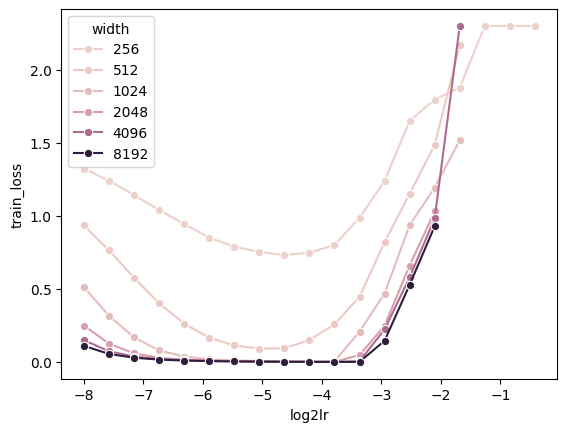

In [48]:
import json

with open('mup_mlp_logs.json', 'r') as f:
    logs = json.load(f)
logs_df = pd.DataFrame(logs)

sns.lineplot(x='log2lr', y='train_loss', hue='width', data=logs_df[(logs_df['model_type']=='muP MLP')&
                                                                   (logs_df['train_loss']<5)&
                                                                   (logs_df['epoch']==20)], marker='o')

<AxesSubplot:xlabel='log2lr', ylabel='train_loss'>

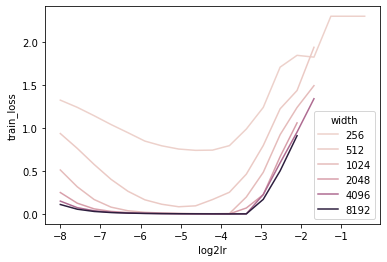

In [ ]:
logs_df = pd.DataFrame(logs)
sns.lineplot(x='log2lr', y='train_loss', hue='width', data=logs_df[(logs_df['model_type']=='muP MLP')&
                                                                   (logs_df['train_loss']<5)&
                                                                   (logs_df['epoch']==20)])

<AxesSubplot:xlabel='log2lr', ylabel='train_loss'>

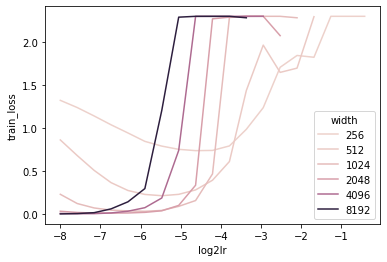

In [ ]:
sns.lineplot(x='log2lr', y='train_loss', hue='width', data=logs_df[(logs_df['model_type']=='SP MLP')&
                                                                   (logs_df['train_loss']<5)&
                                                                   (logs_df['epoch']==20)])